# Test barycenter-based worm straightening on toy example

In [1]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from scipy.ndimage import geometric_transform
from scipy.stats import multivariate_normal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from utils import pixel_dist_3d
from potmods import barycenter_sinkhorn

### Load frames

In [9]:
img_shape = (50, 25, 5)

# Create grid for evaluating densities on
xg, yg, zg = np.mgrid[0:img_shape[0], 0:img_shape[1], 0:img_shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

mu_1 = np.array([20, 10, 3])
mu_2 = np.array([40, 10, 3])
cov = 5 * np.eye(3)

frame_1 = multivariate_normal.pdf(grid, mu_1, cov).reshape(img_shape)
frame_2 = multivariate_normal.pdf(grid, mu_2, cov).reshape(img_shape)

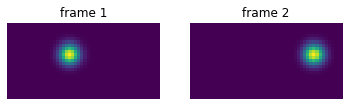

In [11]:
plt.subplot(121)
plt.imshow(np.max(frame_1, 2).T);
plt.title('frame 1')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.max(frame_2, 2).T);
plt.title('frame 2')
plt.axis('off');

### Compute barycenter

In [12]:
# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*img_shape)
M = M_nn / np.median(M_nn)

# Entropic regularization parameter
reg = 1e-3

A = np.hstack([frame_1.reshape(-1, 1), frame_2.reshape(-1, 1)])
bc_vec, u, v, K = barycenter_sinkhorn(A, M, reg)
bc_img = bc_vec.reshape(img_shape)

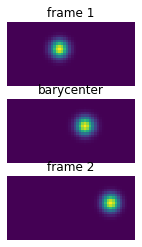

In [15]:
plt.subplot(311)
plt.imshow(np.max(frame_1, 2).T);
plt.title('frame 1')
plt.axis('off')

plt.subplot(312)
plt.imshow(np.max(bc_img, 2).T);
plt.title('barycenter')
plt.axis('off')

plt.subplot(313)
plt.imshow(np.max(frame_2, 2).T);
plt.title('frame 2')
plt.axis('off');

### Extract transport plan

In [16]:
# Frame
frame_idx = 1
frame = frame_1

# Transport plan
u1 = u[:, frame_idx]
v1 = v[:, frame_idx]
P = np.diag(u1) @ K @ np.diag(v1)

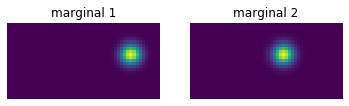

In [18]:
m1_vec = np.sum(P, axis=0)
m2_vec = np.sum(P, axis=1)

m1_img = m1_vec.reshape(img_shape)
m2_img = m2_vec.reshape(img_shape)

plt.subplot(121)
plt.imshow(np.max(m1_img, 2).T)
plt.axis('off')
plt.title('marginal 1')

plt.subplot(122)
plt.imshow(np.max(m2_img, 2).T)
plt.axis('off')
plt.title('marginal 2');

In [23]:
# Compute pushforward from barycenter to original worm
T = P / bc_vec.reshape(-1, 1)

# Get all pixel coordinates
n_grid_pts = img_shape[0] * img_shape[1] * img_shape[2]
grid_vals = grid.reshape(n_grid_pts, 3)

t_vals = T @ grid_vals

In [24]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression(fit_intercept=True))
])
model.fit(grid_vals, t_vals)

beta = model.named_steps['linear'].coef_
alpha = model.named_steps['linear'].intercept_

In [25]:
def inv_map(coords):
    in_arr = np.array(coords).reshape(1, -1)
    out_arr = model.predict(in_arr)
    return tuple(out_arr.flatten())

t_frame = geometric_transform(frame, inv_map)

Text(0.5, 1.0, 'transformed')

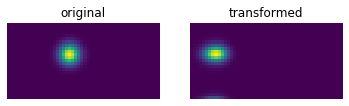

In [26]:
plt.subplot(121)
plt.imshow(np.max(frame, 2).T)
plt.axis('off')
plt.title('original')

plt.subplot(122)
plt.imshow(np.max(t_frame, 2).T)
plt.axis('off')
plt.title('transformed')